<a href="https://colab.research.google.com/github/ayberkozcan/pytorch-computer-vision/blob/main/Handwritten_Digits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digits Classification Using PyTorch

## Importing Libraries

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading MNIST Dataset

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.15MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Recognizing our Dataset

In [4]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

There are 60.000 training samples and 10.000 testing samples.

In [5]:
# Let's see classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


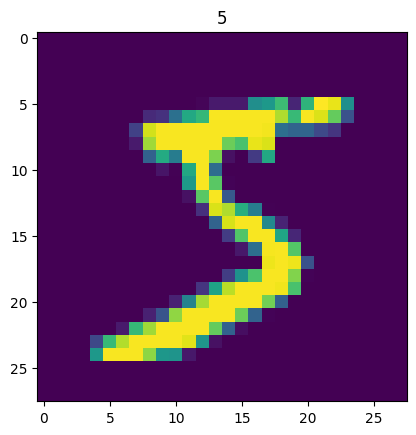

In [6]:
image, label = train_data[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)
plt.show()

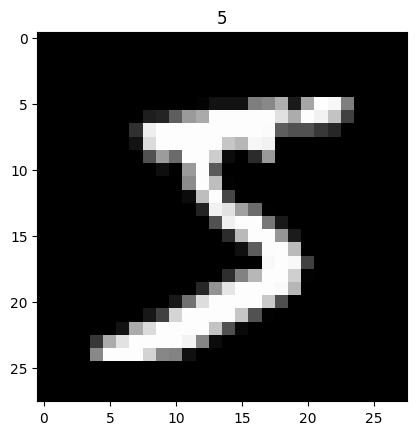

In [7]:
# Let's turn the image into grayscale
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
plt.show()

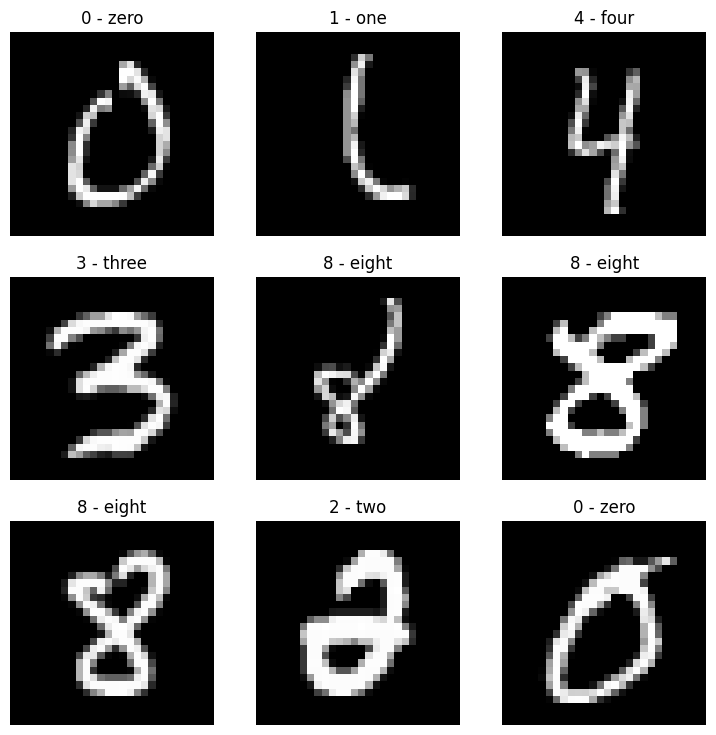

In [8]:
# Let's plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False
)

In [10]:
print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train dataloader: 938
Length of test dataloader: 157


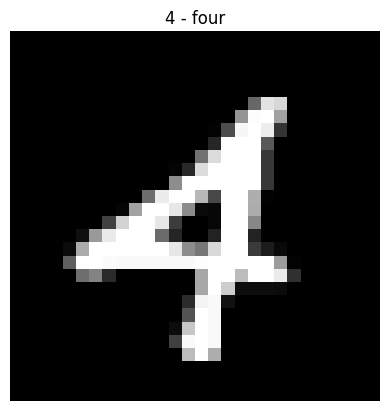

In [11]:
# Let's see a sample
train_features_batch, train_labels_batch = next(iter(train_dataloader))

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");

## Building a Model

In [12]:
class MNISTModel_0(nn.Module):
  def __init__(self, input_shape=784, hidden_units=128, output_shape=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [13]:
model_0 = MNISTModel_0(
    input_shape=784,
    hidden_units=128,
    output_shape=len(class_names)
)
model_0

MNISTModel_0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [14]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists!")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [15]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Measuring Time Function

We are going to measure time for different models.

In [16]:
from timeit import default_timer as timer

def measure_time(start, end):
  total_time = end - start
  return total_time

## Training Loop and Training a Model

In [17]:
from tqdm.auto import tqdm

train_time_start = timer()

epochs = 10

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(
        y_true=y,
        y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model_0(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

      accuracy = accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
      test_acc += accuracy

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

# Measuring time
train_time_end = timer()
total_time_on_model_0 = measure_time(train_time_start, train_time_end)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.44694 | Train Accuracy: 88.00%, Test Loss: 0.26919 | Test Accuracy: 92.04%

Epoch: 1
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.22480 | Train Accuracy: 93.54%, Test Loss: 0.18559 | Test Accuracy: 94.61%

Epoch: 2
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.16531 | Train Accuracy: 95.27%, Test Loss: 0.14476 | Test Accuracy: 95.88%

Epoch: 3
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.13187 | Train Accuracy: 96.25%, Test Loss: 0.12217 | Test Accuracy: 96.27%

Epoch: 4
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.11069 | Train Accuracy: 96.83%, Test Loss: 0.10713 | Test Accuracy: 96.75%

Epoch: 5
------
Looked at 0/60000 s

In [18]:
loss = results['train_loss']
test_loss = results['test_loss']

accuracy = results['train_acc']
test_accuracy = results['test_acc']

epochs = range(len(results['train_loss']))

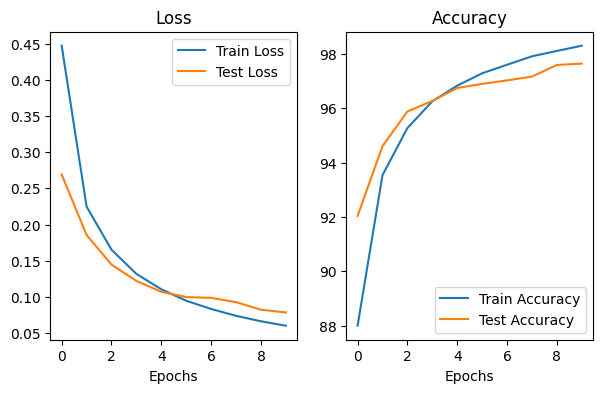

In [19]:
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

Looks like our model work pretty good.

Let's make a confusion matrix for further prediction evaluation.

## Confusion Matrix

First, we're going to make predictions with our trained model.

In [20]:
# Progress Bar
from tqdm.auto import tqdm

y_preds = []

model_0.to(device)

model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_0(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/157 [00:00<?, ?it/s]

And now, we're going to import or install some libraries for confusion matrix and plotting.

In [21]:
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 772.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00


In [22]:
import torchmetrics, mlxtend

In [23]:
print(f"torchmetrics version: {torchmetrics.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

torchmetrics version: 1.6.1
mlxtend version: 0.23.4


In [24]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass"
)
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=test_data.targets
)

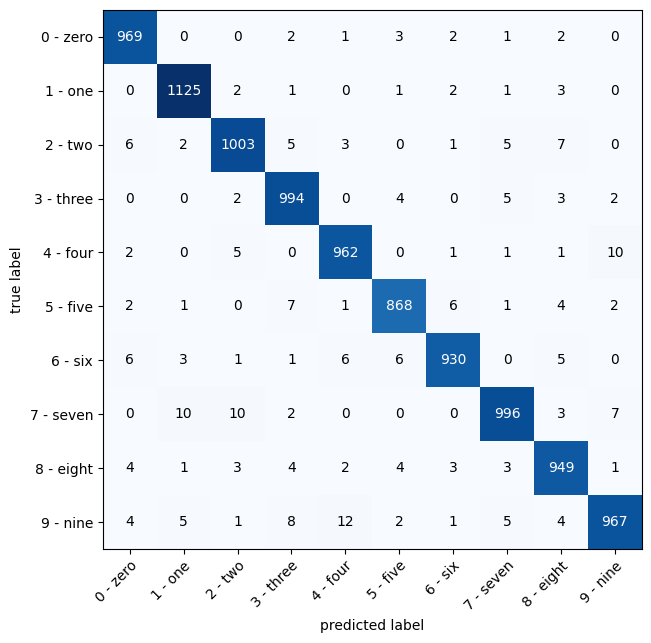

In [25]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## Saving Model

We can save our model parameters to use it later.

In [26]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(
    parents=True,
    exist_ok=True
)

MODEL_NAME = "mnist_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(
    obj=model_0.state_dict(),
    f=MODEL_SAVE_PATH
)

## Making Prediction on my Handwritten Digit Image

In [96]:
import requests

custom_image_path = "digit.jpg"

In [97]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")

Custom image tensor:
tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 206, 208])



We need to convert the tensor values to float32.

In [98]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")

Custom image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

Custom image shape: torch.Size([3, 206, 208])



Let's see our custom image and make a prediction.

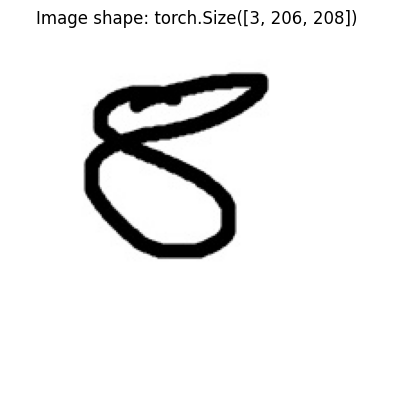

In [99]:
plt.imshow(custom_image.permute(1, 2, 0)) # CHW -> HWC
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [100]:
print(f"Custom Image shape: {custom_image.shape}")
print(f"Image in dataset shape: {image.shape}")

Custom Image shape: torch.Size([3, 206, 208])
Image in dataset shape: torch.Size([1, 28, 28])


We need to resize our image and change its color channels parameter.

In [101]:
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: 1.0 - x)
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 206, 208])
Transformed shape: torch.Size([1, 28, 28])


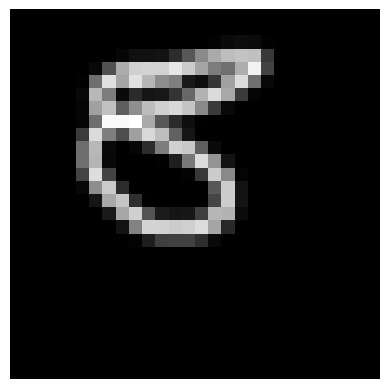

In [102]:
plt.imshow(custom_image_transformed.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

We also need to adjust the batch size.

In [103]:
model_0.eval()
with torch.inference_mode():
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0).to(device)

  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Custom image shape with batch size: {custom_image_transformed_with_batch_size.shape}")

  custom_image_pred = model_0(custom_image_transformed_with_batch_size)

Custom image transformed shape: torch.Size([1, 28, 28])
Custom image shape with batch size: torch.Size([1, 1, 28, 28])


In [104]:
custom_image_pred

tensor([[-2.0249, -2.2618, -0.4484,  2.8541, -3.2947,  1.1978, -2.9379, -0.6924,
          3.8985,  3.3343]], device='cuda:0')

In [105]:
print(f"Prediction logits: {custom_image_pred}")

# Converting logits to prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Lastly converting prediction probabilities to prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-2.0249, -2.2618, -0.4484,  2.8541, -3.2947,  1.1978, -2.9379, -0.6924,
          3.8985,  3.3343]], device='cuda:0')
Prediction probabilities: tensor([[1.3263e-03, 1.0466e-03, 6.4169e-03, 1.7441e-01, 3.7256e-04, 3.3288e-02,
         5.3230e-04, 5.0275e-03, 4.9565e-01, 2.8193e-01]], device='cuda:0')
Prediction label: tensor([8], device='cuda:0')


Let's see what "tensor([8], device='cuda:0')" means.

In [106]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'8 - eight'